In [4]:
import copy
from typing import Optional, List

from fastai.distributed import *
from fastai.vision.all import *

import torch
import torch.nn.functional as F
from torch import nn, Tensor
import torchvision.transforms as T

from scipy.spatial import distance
import numpy as np

from models.encoder import EncoderModule
from models.backbone import Backbone, NoBackbone
from models.utils.new_losses import *
from models.utils.joiner3 import *

In [5]:
from PIL import Image
import requests

w = width = 256
h = height = 256
grid_l=1 
pf="1"
alpha=1

transform = T.Compose([
T.Resize((h,w)),
T.ToTensor(),
])

Input shape: torch.Size([2, 3, 256, 256])


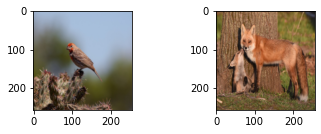

In [7]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'
url2 = 'https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/elephant_1280p.jpg?itok=UT_i17Yh'
#im = Image.open(requests.get(url, stream=True).raw)
#img = transform(im).unsqueeze(0)
im = Image.open('sample_images/image'+str(4)+'.jpeg')
img = transform(im).unsqueeze(0)#.to(device)
im2 = Image.open(requests.get(url, stream=True).raw)
img2 = transform(im2).unsqueeze(0)
batch= torch.cat((img, img2), 0)
print("Input shape:", batch.shape)
plt.subplot(221)
plt.imshow(batch[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(batch[1].cpu().permute(1, 2, 0))

In [9]:
class Curating_of_attention_mask(nn.Module):
    def __init__(self, patch_size=32, width=256, height=256, map_width=20, map_height=20, grid_l=1, pf="1"):
        super().__init__()
        self.grid_l = grid_l
        self.width = width #used
        self.height = height #used
        self.patch_size = patch_size #used
        self.qt_grids = (width//patch_size)**2 #used
        self.map_width = map_width
        self.map_height = map_height
        self.pf = pf
        self.gd_list = self.grids_list(self.width, self.height, self.patch_size) 
        self.grids_matrix = self.grids_matrix(self.map_width, self.map_height, self.grid_l)
        
        
    def grids_list(self, width, height, patch_size): #COMPUTED ONCE BEFORE TRAINING
        w = width
        h = height
        qt_hor_grids = w//patch_size
        qt_ver_grids = h//patch_size
        qtd_grids = qt_hor_grids*qt_ver_grids
        c = 0
        grids_list = []
        for i in range(qtd_grids):
            hor_pos = i//qt_hor_grids
            ver_pos = c
            c = c+1
            grid = [hor_pos,ver_pos]
            grids_list.append(grid)
            if c == qt_ver_grids:
                c=0
        return grids_list
        
        
    def grids_matrix(self, map_width, map_height, grid_l):

        w = map_width
        h = map_height
        len_input_seq = h*w
        qt_hor_grids = w//grid_l
        qt_ver_grids = h//grid_l


        grid_list = []
        for i in range(h):
            row_grid_list = []
            preliminar_ver_grid = i//grid_l
            if preliminar_ver_grid != 0:
                preliminar_ver_grid = preliminar_ver_grid*qt_hor_grids

            for h in range(w):
                preliminar_grid = h//grid_l+preliminar_ver_grid
                row_grid_list.append(preliminar_grid)

            grid_list.append(row_grid_list)
        grid_matrix = torch.tensor(np.array(grid_list))

        return grid_matrix
        
        
    def img_patches(self, batch, patch_size):
        #torch.Tensor.unfold(dimension, size, step)
        #slices the images into grid_l*grid_l size patches
        patches = batch.data.unfold(1, 3, 3).unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        a, b, c, d, e, f, g = patches.shape
        patches = patches.reshape(a, c, d, e, f, g)
        #print(patches.shape)
        return patches


    def grid_gram_matrix(self, patches):

        a, b, c, d, e, f = patches.shape
        # a=batch size
        # b=horizontal patches
        # c = vertical patches
        # d=number of feature maps
        # (e,f)=dimensions of a f. map (N=e*f)

        features = patches.reshape(a * b * c, d, e*f)  # resise F_XL into \hat F_XL
        #print(features.shape)
        # compute the gram product

        #G = torch.mm(features[0], features[0].t())

        #for i in range(1,a*b*c):
        #    g = torch.mm(features[i], features[i].t())
        #    G= torch.cat((G, g), 0)


        #G = G.div(d * e * f).reshape(a, b, c, d, d)
        
        feat_t = features.permute(0,2,1)
        G = torch.bmm(features, feat_t)
        G = G.div(d * e * f).reshape(a, b, c, d, d)

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.

        return G



#     def gram_dist_matrix(self, batch, patch_size):
#         patches = self.img_patches(batch, patch_size)
#         #print(patches.shape)
#         Grid = self.grid_gram_matrix(patches)
#         #print(Grid.shape)
#         bs = batch.shape[0]
#         #print(bs)
#         MSE = nn.MSELoss()

#         mse_grid = []
#         for k in range(bs):
#             dist_grid = []
#             for g in range(len(self.grids_list)):
#                 dist_pair_list = []
#                 for n in range(len(self.grids_list)):
#                     dist_pair_list.append(MSE(Grid[k][self.grids_list[g][0]][self.grids_list[g][1]], Grid[k][self.grids_list[n][0]][self.grids_list[n][1]]))
#                 dist_grid.append(dist_pair_list)
#             mse_grid.append(dist_grid)

#         dist_matrix = torch.tensor(mse_grid)
#         #dist_matrix = torch.tensor(np.array(mse_grid))

#         for i in range(bs):
#             dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
#             dist_matrix[i] -= dist_matrix[i].min(1, keepdim=True)[0]
#             dist_matrix[i] /= dist_matrix[i].max(1, keepdim=True)[0]
#             dist_matrix[i] = dist_matrix[i].view(1, len(self.grids_list), len(self.grids_list))

#         return dist_matrix
    
#     def gram_dist_matrix(self, batch, patch_size):
#         patches = self.img_patches(batch, patch_size)
#         #print(patches.shape)
#         Grid = self.grid_gram_matrix(patches)
#         #print(Grid.shape)
#         bs = batch.shape[0]
#         #print(bs)
#         MSE = nn.MSELoss()

#         mse_grid = torch.Tensor([])
#         for k in range(bs):
#             dist_grid = torch.Tensor([])
#             for g in range(len(self.gd_list)):
#                 dist_pair_list = torch.Tensor([])
#                 for n in range(len(self.gd_list)):
#                     dist_pair_list = torch.cat((dist_pair_list, torch.Tensor([MSE(Grid[k][self.gd_list[g][0]][self.gd_list[g][1]], Grid[k][self.gd_list[n][0]][self.gd_list[n][1]])]).unsqueeze(0)),1)

#                 dist_grid = torch.cat((dist_grid, dist_pair_list),0)

#             #mse_grid.append(dist_grid)
#             mse_grid = torch.cat((mse_grid, dist_grid.unsqueeze(0)),0)

#         dist_matrix = mse_grid
#         #dist_matrix = torch.tensor(np.array(mse_grid))

#         for i in range(bs):
#             dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
#             dist_matrix[i] -= dist_matrix[i].min(1, keepdim=True)[0]
#             dist_matrix[i] /= dist_matrix[i].max(1, keepdim=True)[0]
#             dist_matrix[i] = dist_matrix[i].view(1, len(self.gd_list), len(self.gd_list))

#         return dist_matrix
    
    def gram_dist_matrix(self, batch, grid_l):
        patches = self.img_patches(batch, grid_l)
        #print(patches.shape)
        Grid = self.grid_gram_matrix(patches)
        #print(Grid.shape)
        bs = batch.shape[0]

        mse_grid = torch.Tensor([])
        for k in range(bs):
            g = Grid[k].reshape(self.qt_grids,3,3)
            gh = g.unsqueeze(1)
            gv = g.unsqueeze(0)

            ghe = gh.repeat(1,self.qt_grids,1,1).reshape(self.qt_grids*self.qt_grids,9)
            gve = gv.repeat(self.qt_grids,1,1,1).reshape(self.qt_grids*self.qt_grids,9)

            pdist = nn.PairwiseDistance(p=0.1)
            output = pdist(ghe, gve).reshape(self.qt_grids,self.qt_grids)

            output -= output.min()
            output /= output.max()

            mse_grid = torch.cat((mse_grid, output.unsqueeze(0)),0)

        return mse_grid


    def penalty_factor(self, dist_matrix, penalty_factor="1", alpha=1):
        if penalty_factor == "1" or penalty_factor =="distraction":
            pf_matrix = ((dist_matrix+1))**alpha
            return pf_matrix
        if penalty_factor == "2" or penalty_factor =="misdirection":
            pf_matrix = alpha*((torch.max(dist_matrix)//2)-dist_matrix+0.1)**3
            return pf_matrix


    def penalty_matrix(self, map_width, map_height, grid_matrix, dist_matrix, grid_l, pf):
        bs,_,_ = dist_matrix.shape
        pep = []
        for s in range(bs):
            pf_matrix = self.penalty_factor(dist_matrix[s], penalty_factor=pf, alpha=1)
            w = map_width
            h = map_height

            qt_hor_grids = w//grid_l
            qt_ver_grids = h//grid_l
            qtd_grids = qt_hor_grids*qt_ver_grids

            penalty_mask = []
            for i in range(qtd_grids):
                ref_column = pf_matrix[i]
                p_matrix = grid_matrix.type(torch.FloatTensor)
                for j in range(1,len(ref_column)):
                    #print(float(j))
                    p_matrix[p_matrix==j]=float(ref_column[j])
                p_matrix[p_matrix==0]=float(ref_column[0])
                penalty_mask.append(p_matrix)

            #print(len(penalty_mask))    

            penalty_enc = []
            for i in range(h):
                penalty_row = []
                for j in range(w):
                    #print(grid_matrix[i,j])
                    #print(penalty_mask[grid_matrix[i,j]].shape)
                    penalty_row.append(penalty_mask[grid_matrix[i,j]])
                    #print(len(penalty_row))
                generic_tensor = Tensor(h,w)
                penalty_row_tensor = torch.cat(penalty_row, out=generic_tensor)
                penalty_enc.append(penalty_row_tensor)
                #print(penalty_row_tensor.shape)
                #break

            b = torch.Tensor(h, w, h, w)
            c=torch.cat(penalty_enc, out=b)
            c = c.view(h, w, h, w)
            pep.append(c)

        d = torch.Tensor(bs, h, w, h, w)
        penalty_encoding_pattern = torch.cat(pep, out=d)
        penalty_encoding_pattern = penalty_encoding_pattern.view(bs, h, w, h, w)

        return penalty_encoding_pattern
        
    def forward(self, batch):
        
        batch = batch#.unsqueeze(0)
        
        dist_matrix = self.gram_dist_matrix(batch, self.patch_size)
        penalty_mask = self.penalty_matrix(self.map_width, self.map_height, self.grids_matrix, dist_matrix, self.grid_l, self.pf)
        
        #pattn = penalty_mask.squeeze(0)
        
        return dist_matrix, penalty_mask

In [10]:
Latt = Curating_of_attention_mask(patch_size=32, width=256, height=256, map_width=8, map_height=8, grid_l=1, pf="1")
#Latt = GM_Mask(patch_size=32, width=256, height=256)

In [11]:
pmtx = Latt(batch)

torch.Size([2, 64, 64])


(-0.5, 63.5, 63.5, -0.5)

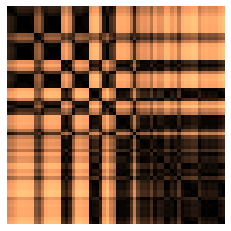

In [23]:
print(pmtx[0].shape)
plt.imshow(pmtx[0][0].cpu().detach().numpy(),cmap='copper', interpolation='nearest')#,vmax=threshold)
plt.axis('off')

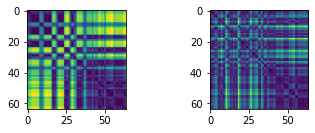

In [13]:
plt.subplot(221)
plt.imshow(pmtx[0][0])
plt.subplot(222)
plt.imshow(pmtx[0][1])

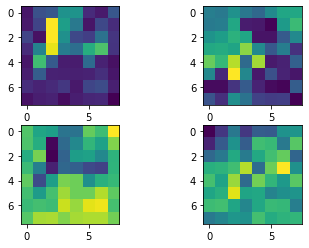

In [11]:
plt.subplot(221)
plt.imshow(pmtx[1][0][7][7])
plt.subplot(222)
plt.imshow(pmtx[1][1][7][7])
plt.subplot(223)
plt.imshow(pmtx[1][0][2][2])
plt.subplot(224)
plt.imshow(pmtx[1][1][0][0])

In [11]:
# out = F.interpolate(pmtx, size=40)
# out2 = F.interpolate(pmtx[1], size=10)
# out.shape

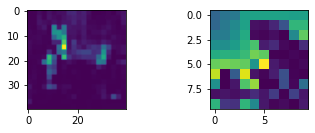

In [82]:
plt.subplot(221)
plt.imshow(out[0][0])#.cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(out2[15][15])#.cpu().permute(1, 2, 0))

In [42]:
a = torch.Tensor([])
for i in range(8):
    a = torch.cat((a,torch.Tensor([i])),0)
a.shape

torch.Size([8])

torch.Size([2, 64, 1, 3, 3])
torch.Size([2, 1, 64, 3, 3])
torch.Size([2, 9, 4096])
torch.Size([2, 9, 4096])
tensor(3486.7852)
tensor(7.0202e+08)
tensor([[3486.7852],
        [3486.7852]])
tensor([[2.9201e+08],
        [7.0202e+08]])
tensor([[0.],
        [0.]])
tensor([[1.0000],
        [1.0000]])
torch.Size([2, 64, 64])
tensor(0.)
tensor(1.0000)


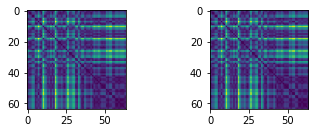

In [18]:
g = grid.reshape(2,64,3,3)
gh = g.unsqueeze(2)
gv = g.unsqueeze(1)
print(gh.shape)
print(gv.shape)

ghe = gh.repeat(1,1,64,1,1).reshape(2,4096,9).permute(0, 2, 1)
gve = gv.repeat(1,64,1,1,1).reshape(2,4096,9).permute(0, 2, 1)
print(ghe.shape)
print(gve.shape)

pdist = nn.PairwiseDistance(p=0.1)
output = pdist(ghe, gve).reshape(2,64,64)

print(output.min())
print(output.max())

#for i in range(2):
#    output[i] -= output[i].min()
#    output[i] /= output[i].max()

#output -= output.min(1, keepdim=True)[0]
#output /= output.max(1, keepdim=True)[0]

output = output.view(output.size(0), -1)
print(output.min(1, keepdim=True)[0])
print(output.max(1, keepdim=True)[0])
low = output.min(1, keepdim=True)[0]
high = output.max(1, keepdim=True)[0]
output = output-low
output = output/(high-low)
#output -= output.min(1, keepdim=True)[0]
#output /= output.max(1, keepdim=True)[0]
print(output.min(1, keepdim=True)[0])
print(output.max(1, keepdim=True)[0])
output = output.view(2, 64, 64)

# output -= output.min()
# output /= output.max()
print(output.shape)
print(output.min())
print(output.max())
plt.subplot(221)
plt.imshow(output[0])
plt.subplot(222)
plt.imshow(pmtx[0][0])

In [16]:
batch_size = 3
height = 2
width = 2

A = torch.randint(2, 11, (batch_size, height, width)).float()
AA = A.clone()
print(A)

AA = AA.view(A.size(0), -1)
AA -= AA.min(1, keepdim=True)[0]
AA /= AA.max(1, keepdim=True)[0]
AA = AA.view(batch_size, height, width)

# # I can get what I want from below for-loop solution
# for i in range(batch_size):
#     A[i] -= torch.min(A[i])
#     A[i] /= torch.max(A[i])

# # Your solution
# AA -= AA.min(1, keepdim=True)[0]
# AA /= AA.max(1, keepdim=True)[0]

print(A)  # A and AA are different
print(AA)

tensor([[[ 8.,  9.],
         [ 4., 10.]],

        [[10.,  3.],
         [10., 10.]],

        [[ 5.,  5.],
         [ 4.,  8.]]])
tensor([[[ 8.,  9.],
         [ 4., 10.]],

        [[10.,  3.],
         [10., 10.]],

        [[ 5.,  5.],
         [ 4.,  8.]]])
tensor([[[0.6667, 0.8333],
         [0.0000, 1.0000]],

        [[1.0000, 0.0000],
         [1.0000, 1.0000]],

        [[0.2500, 0.2500],
         [0.0000, 1.0000]]])


In [ ]:
AA = AA.view(A.size(0), -1)
AA -= AA.min(1, keepdim=True)[0]
AA /= AA.max(1, keepdim=True)[0]
AA = AA.view(batch_size, height, width)

In [52]:
print(output[1].min())
print(output[1].max())

tensor(0.)
tensor(1.)


In [37]:
a, b, c, d, e, f = patches.shape
print(patches.shape)
# a=batch size
# b=horizontal patches
# c = vertical patches
# d=number of feature maps
# (e,f)=dimensions of a f. map (N=e*f)

features = patches.reshape(a * b * c, d, e*f)  # resise F_XL into \hat F_XL
print(features.shape)
# compute the gram product

G = torch.mm(features[0], features[0].t())

for i in range(1,a*b*c):
    g = torch.mm(features[i], features[i].t())
    G= torch.cat((G, g), 0)

print(G.shape)
G = G.div(d * e * f).reshape(a, b, c, d, d)
print(G.shape)

torch.Size([2, 8, 8, 3, 32, 32])
torch.Size([128, 3, 1024])
torch.Size([384, 3])
torch.Size([2, 8, 8, 3, 3])


In [38]:
feat_t = features.permute(0,2,1)
feat_t.shape
G2 = torch.bmm(features, feat_t)
print(G2.shape)
G2 = G2.div(d * e * f).reshape(a, b, c, d, d)
print(G2.shape)

torch.Size([128, 3, 3])
torch.Size([2, 8, 8, 3, 3])


In [41]:
G == G2

tensor([[[[[True, True, True],
           [True, True, True],
           [True, True, True]],

          [[True, True, True],
           [True, True, True],
           [True, True, True]],

          [[True, True, True],
           [True, True, True],
           [True, True, True]],

          ...,

          [[True, True, True],
           [True, True, True],
           [True, True, True]],

          [[True, True, True],
           [True, True, True],
           [True, True, True]],

          [[True, True, True],
           [True, True, True],
           [True, True, True]]],


         [[[True, True, True],
           [True, True, True],
           [True, True, True]],

          [[True, True, True],
           [True, True, True],
           [True, True, True]],

          [[True, True, True],
           [True, True, True],
           [True, True, True]],

          ...,

          [[True, True, True],
           [True, True, True],
           [True, True, True]],

          [[True

In [61]:
#expanded_matrix1 = a.index_select(0, indices)
#expanded_matrix1
b = b.repeat(1,8).reshape(64,1)
c = c.repeat(8,1).reshape(64,1)
print(b.shape)
print(c.shape)

torch.Size([64, 1])
torch.Size([64, 1])


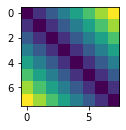

In [69]:
pdist = nn.PairwiseDistance(p=2)
output = pdist(b, c).reshape(8,8)
plt.subplot(221)
plt.imshow(output)

In [9]:
# Pre processing:
#Create a list of grids:

def grids_list(width, height, grid_l): #COMPUTED ONCE BEFORE TRAINING
    w = width
    h = height
    qt_hor_grids = w//grid_l
    qt_ver_grids = h//grid_l
    qtd_grids = qt_hor_grids*qt_ver_grids
    c = 0
    grids_list = []
    for i in range(qtd_grids):
        hor_pos = i//qt_hor_grids
        ver_pos = c
        c = c+1
        grid = [hor_pos,ver_pos]
        grids_list.append(grid)
        if c == qt_ver_grids:
            c=0
    return grids_list

gd_list = grids_list(8,8,1)
len(gd_list)

64

In [10]:
#Compute a Matrix with the right position of all grids

def grids_matrix(width, height, patch_size):

    w = width
    h = height
    len_input_seq = h*w
    qt_hor_grids = w//grid_l
    qt_ver_grids = h//grid_l


    grid_list = []
    for i in range(h):
        row_grid_list = []
        preliminar_ver_grid = i//grid_l
        if preliminar_ver_grid != 0:
            preliminar_ver_grid = preliminar_ver_grid*qt_hor_grids

        for h in range(w):
            preliminar_grid = h//grid_l+preliminar_ver_grid
            row_grid_list.append(preliminar_grid)

        grid_list.append(row_grid_list)
    grid_matrix = torch.tensor(np.array(grid_list))

    return grid_matrix

gd_matrix = grids_matrix(8,8,1)
gd_matrix.shape

torch.Size([8, 8])

In [11]:
#1 - Create the image patches

def img_patches(batch, grid_l):
    #torch.Tensor.unfold(dimension, size, step)
    #slices the images into grid_l*grid_l size patches
    patches = batch.data.unfold(1, 3, 3).unfold(2, grid_l, grid_l).unfold(3, grid_l, grid_l)
    a, b, c, d, e, f, g = patches.shape
    patches = patches.reshape(a, c, d, e, f, g)
    #print(patches.shape)
    return patches
    
patches = img_patches(batch=batch, grid_l=32)
print(patches.shape)

torch.Size([2, 8, 8, 3, 32, 32])


In [12]:
# 2 - Define a Grid from the patches

def grid_gram_matrix(patches):

    a, b, c, d, e, f = patches.shape
    # a=batch size
    # b=horizontal patches
    # c = vertical patches
    # d=number of feature maps
    # (e,f)=dimensions of a f. map (N=e*f)

    features = patches.reshape(a * b * c, d, e*f)  # resise F_XL into \hat F_XL
    #print(features.shape)
    # compute the gram product

    G = torch.mm(features[0], features[0].t())

    for i in range(1,a*b*c):
        g = torch.mm(features[i], features[i].t())
        G= torch.cat((G, g), 0)


    G = G.div(d * e * f).reshape(a, b, c, d, d)

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.

    return G

grid = grid_gram_matrix(patches)
print(grid.shape)

torch.Size([2, 8, 8, 3, 3])


In [13]:
#Compute the distance matrix withim all gram patches
def gram_dist_matrix(batch, patch_size):
    patches = img_patches(batch, patch_size)
    #print(patches.shape)
    Grid = grid_gram_matrix(patches)
    #print(Grid.shape)
    bs = batch.shape[0]
    #print(bs)
    MSE = nn.MSELoss()

    mse_grid = []
    for k in range(bs):
        dist_grid = []
        for g in range(len(gd_list)):
            dist_pair_list = []
            for n in range(len(gd_list)):
                dist_pair_list.append(MSE(Grid[k][gd_list[g][0]][gd_list[g][1]], Grid[k][gd_list[n][0]][gd_list[n][1]]))
            dist_grid.append(dist_pair_list)
        mse_grid.append(dist_grid)

    dist_matrix = torch.tensor(mse_grid)
    #dist_matrix = torch.tensor(np.array(mse_grid))

    for i in range(bs):
        dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
        dist_matrix[i] -= dist_matrix[i].min(1, keepdim=True)[0]
        dist_matrix[i] /= dist_matrix[i].max(1, keepdim=True)[0]
        dist_matrix[i] = dist_matrix[i].view(1, len(gd_list), len(gd_list))

    return dist_matrix

grm_matrix = gram_dist_matrix(batch, patch_size=16)

In [48]:
x = torch.Tensor([])

In [82]:
MSE = nn.MSELoss()
a = torch.Tensor([MSE(grid[0][gd_list[0][0]][gd_list[0][1]], grid[0][gd_list[1][0]][gd_list[1][1]])]).unsqueeze(0)
b = torch.Tensor([MSE(grid[0][gd_list[0][0]][gd_list[0][1]], grid[0][gd_list[2][0]][gd_list[2][1]])]).unsqueeze(0)

In [93]:
a.shape

torch.Size([1, 1])

In [101]:
c = torch.cat((a, b),1)
c = torch.cat((c, b),1)
d = torch.cat((a, b),1)
d = torch.cat((d, b),1)
d.shape

torch.Size([1, 3])

In [102]:
e = torch.cat((c, d),0)
print(e.shape)
e

torch.Size([2, 3])


tensor([[0.0002, 0.0002, 0.0002],
        [0.0002, 0.0002, 0.0002]])

In [95]:
f = torch.cat((e, d),0)
f.shape

torch.Size([3, 2])

In [98]:
dist_grid = torch.Tensor([])
for g in range(len(gd_list)):
    dist_pair_list = torch.Tensor([])
    for n in range(len(gd_list)):
        dist_pair_list = torch.cat((dist_pair_list, torch.Tensor([MSE(grid[0][gd_list[g][0]][gd_list[g][1]], grid[0][gd_list[n][0]][gd_list[n][1]])]).unsqueeze(0)),1)
        
    dist_grid = torch.cat((dist_grid, dist_pair_list),0)

In [99]:
dist_grid.shape

torch.Size([64, 64])

In [55]:
#Compute the distance matrix withim all gram patches
def gram_dist_matrix(batch, grid_l):
    patches = img_patches(batch, grid_l)
    #print(patches.shape)
    Grid = grid_gram_matrix(patches)
    #print(Grid.shape)
    bs = batch.shape[0]

    mse_grid = torch.Tensor([])
    for k in range(bs):
        g = Grid[k].reshape(64,3,3)
        gh = g.unsqueeze(1)
        gv = g.unsqueeze(0)

        ghe = gh.repeat(1,64,1,1).reshape(4096,9)
        gve = gv.repeat(64,1,1,1).reshape(4096,9)

        pdist = nn.PairwiseDistance(p=0.1)
        output = pdist(ghe, gve).reshape(64,64)

        output -= output.min()
        output /= output.max()

        mse_grid = torch.cat((mse_grid, output.unsqueeze(0)),0)

    return mse_grid

grm_matrix = gram_dist_matrix(batch, grid_l=32)

In [56]:
grm_matrix.shape

torch.Size([2, 64, 64])

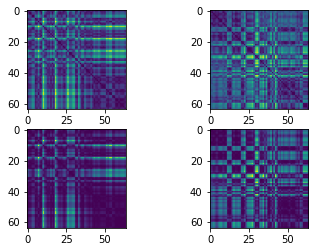

In [57]:
plt.subplot(221)
plt.imshow(grm_matrix[0])
plt.subplot(222)
plt.imshow(grm_matrix[1])
plt.subplot(223)
plt.imshow(pmtx[0])
plt.subplot(224)
plt.imshow(pmtx[1])

In [58]:
grm_matrix[1]

tensor([[0.0000, 0.0724, 0.1776,  ..., 0.2723, 0.2859, 0.2923],
        [0.0724, 0.0000, 0.1051,  ..., 0.3639, 0.3686, 0.2752],
        [0.1776, 0.1051, 0.0000,  ..., 0.4370, 0.4322, 0.3452],
        ...,
        [0.2723, 0.3639, 0.4370,  ..., 0.0000, 0.0048, 0.1205],
        [0.2859, 0.3686, 0.4322,  ..., 0.0048, 0.0000, 0.1253],
        [0.2923, 0.2752, 0.3452,  ..., 0.1205, 0.1253, 0.0000]])

In [32]:
def penalty_factor(dist_matrix, penalty_factor="1", alpha=1):
    if penalty_factor == "1" or penalty_factor =="distraction":
        pf_matrix = ((dist_matrix+1))**alpha
        return pf_matrix
    if penalty_factor == "2" or penalty_factor =="misdirection":
        pf_matrix = alpha*((torch.max(dist_matrix)//2)-dist_matrix+0.1)**3
        return pf_matrix


In [33]:
def penalty_matrix(map_width, map_height, grid_matrix, dist_matrix, grid_l=1):
    bs,_,_ = dist_matrix.shape
    pep = []
    for s in range(bs):
        pf_matrix = penalty_factor(dist_matrix[s], penalty_factor="1", alpha=1)
        w = map_width
        h = map_height

        qt_hor_grids = w//grid_l
        qt_ver_grids = h//grid_l
        qtd_grids = qt_hor_grids*qt_ver_grids

        penalty_mask = []
        for i in range(qtd_grids):
            ref_column = pf_matrix[i]
            p_matrix = grid_matrix.type(torch.FloatTensor)
            for j in range(1,len(ref_column)):
                #print(float(j))
                p_matrix[p_matrix==j]=float(ref_column[j])
            p_matrix[p_matrix==0]=float(ref_column[0])
            penalty_mask.append(p_matrix)

        #print(len(penalty_mask))    

        penalty_enc = []
        for i in range(h):
            penalty_row = []
            for j in range(w):
                #print(grid_matrix[i,j])
                #print(penalty_mask[grid_matrix[i,j]].shape)
                penalty_row.append(penalty_mask[grid_matrix[i,j]])
                #print(len(penalty_row))
            generic_tensor = Tensor(h,w)
            penalty_row_tensor = torch.cat(penalty_row, out=generic_tensor)
            penalty_enc.append(penalty_row_tensor)
            #print(penalty_row_tensor.shape)
            #break

        b = torch.Tensor(h, w, h, w)
        c=torch.cat(penalty_enc, out=b)
        c = c.view(h, w, h, w)
        pep.append(c)

    d = torch.Tensor(bs, h, w, h, w)
    penalty_encoding_pattern = torch.cat(pep, out=d)
    penalty_encoding_pattern = penalty_encoding_pattern.view(bs, h, w, h, w)

    return penalty_encoding_pattern
pmtx = penalty_matrix(width=20, height=20, grid_matrix=gd_matrix, dist_matrix=grm_matrix, grid_l=1)
pmtx.shape

torch.Size([2, 20, 20, 20, 20])

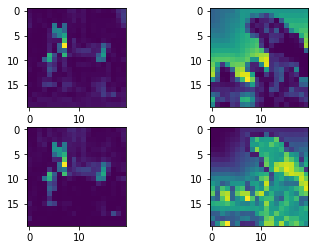

In [35]:
plt.subplot(221)
plt.imshow(pmtx[0][12][19])
plt.subplot(222)
plt.imshow(pmtx[1][12][19])
plt.subplot(223)
plt.imshow(pmtx[0][0][0])
plt.subplot(224)
plt.imshow(pmtx[1][0][0])